In [1]:
from annoy import AnnoyIndex
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import spacy

In [2]:
# n is the number of json files we wish to read (max is 1000)
n = 1

for i in range(1):
    # create the file_name string in order to read in file
    file_name = '../spotify_million_playlist_dataset/data/mpd.slice.0-999.json'

    # Uncomment the following line to show progress
    print(file_name)

    # open the file and store its contents in file_contents
    with open(file_name) as user_file:
        file_contents = user_file.read()

    # we only care about the "playlists" part of this dictionary
    # save the list of playlists in playlist_list
    parsed_json = json.loads(file_contents)
    playlist_list = parsed_json["playlists"]


    # create dataframe if it's first playlist, otherwise append info to existing dataframe
    # the record_path argument tells the json_normalize function how to flatten the data
    # the meta argument tells the json_nomralize function what meta data to keep
    if i == 0:
        data = pd.json_normalize(
            playlist_list,
            record_path="tracks",
            meta=["name", "collaborative", "pid", "num_followers", "num_edits"]
        )
    else:
        data = pd.concat(
            [
                data,
                pd.json_normalize(
                    playlist_list,
                    record_path="tracks",
                    meta=["name", "collaborative", "pid", "num_followers", "num_edits"]
                )
            ],
            ignore_index = True
        )

# For some reason reading in the data creates a new column called pos so I delete it here
data =data.drop(columns=['pos'])


P_names =data['name'].unique()

../spotify_million_playlist_dataset/data/mpd.slice.0-999.json


In [12]:
Beyonce_playlists = data.loc[data['track_uri']=='spotify:track:0WqIKmW4BTrj3eJFmnCKMv']
Beyonce_playlists_name = list(Beyonce_playlists['name']) 

Beyonce_playlists_name


['Throwbacks',
 'tb',
 'SB',
 'w o r k o u t',
 'English ',
 '🤤🤤',
 'running ',
 'lit',
 'randoms',
 "Feelin' Myself",
 'throw backs',
 'old songs ',
 'Guilty pleasure',
 'Throwbacks ',
 'West Coast Swing',
 'Wedding Dance Party',
 'smooth jams',
 'bounce',
 '2000s',
 '00s',
 'Main Playlist',
 '💸💸',
 'WORKOUT',
 'pregame',
 'Camp',
 'nostalgia',
 'LITT ']

# generating playlist vectors

In [6]:
nlp = spacy.load('en_core_web_lg')


In [28]:
p_vec = []

for p in Beyonce_playlists_name:
    doc = nlp(p)
    
    v = np.zeros(300)
    for token in doc:
        v = v + token.vector
        #print(token.text)
        
    p_vec.append(v)

In [57]:
def cosine_similarity(v1,v2):
    "compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)"
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
        
    if sumxx*sumyy == 0:
        return 0
    return sumxy/(sumxx*sumyy)**.5

def pairwise_cosine_similarity(list_of_vectors):
    v = list_of_vectors
    n = len(v)
    
    similarities = []
    
    for i in range(n):
        for j in range(i+1, n):
            sim = cosine_similarity(v[i],v[j])
            
            similarities.append((sim, i, j))
            
    similarities.sort()
    
    return similarities

In [58]:
p_sim =pairwise_cosine_similarity(p_vec)

In [64]:
for i in range(10):
    print(p_sim[-(1+i)][0])
    print(Beyonce_playlists_name[p_sim[-(1+i)][1]])
    print(Beyonce_playlists_name[p_sim[-(1+i)][2]])
    print()
    

1.0
Throwbacks
Throwbacks 

0.5734944806334178
throw backs
bounce

0.5468616601606248
running 
throw backs

0.41638402983391415
Wedding Dance Party
Main Playlist

0.41264760842573234
Throwbacks 
nostalgia

0.41264760842573234
Throwbacks
nostalgia

0.39472216550987926
West Coast Swing
Main Playlist

0.3907923882251679
West Coast Swing
Wedding Dance Party

0.3843840147194541
tb
w o r k o u t

0.3632399591308034
2000s
00s



# Searching vectors

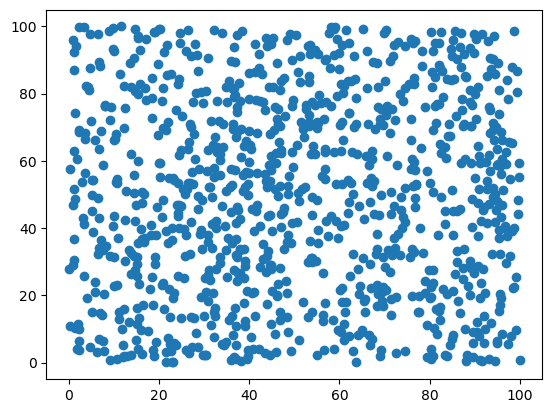

In [40]:
#generate random vectors
np.random.seed(1124356)



N=1000
x = 100*np.random.rand(N)
y = 100*np.random.rand(N)

plt.scatter(x, y)
plt.show()


v = []
for i in range(N):
    v.append((x[i],y[i]))

In [41]:
#test annoy

f = 2

t = AnnoyIndex(f, 'euclidean')
for i in range(N):
    t.add_item(i , v[i])
    
t.build(10)
t.save('test.ann')



True

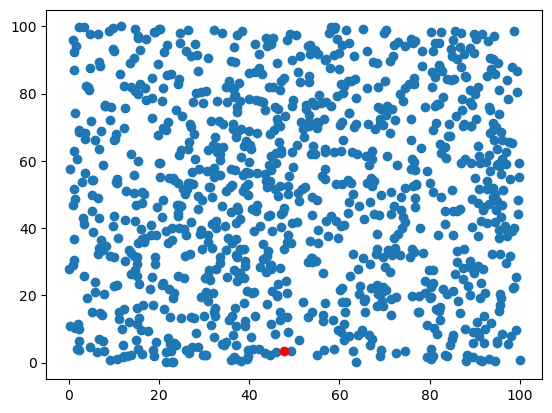

In [42]:
#generate query vector
q = 100*np.random.rand(2)


plt.scatter(x, y)
plt.scatter(q[0],q[1], color = 'red')
plt.show()

In [43]:
nearest_index = t.get_nns_by_vector(q, 5)

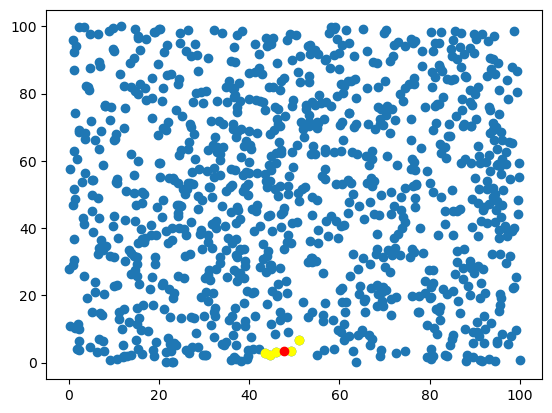

In [44]:
nearest_x=[]
nearest_y=[]
for i in nearest_index:
    nearest_x.append(x[i])
    nearest_y.append(y[i])

    
plt.scatter(x, y)
plt.scatter(nearest_x, nearest_y, color = 'yellow')
plt.scatter(q[0],q[1], color = 'red')
plt.show()    
